# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between frames of normalized magnitude STFTs. 

We'll first explore 1D OT on gaussians followed by 1D OT on pure sine waves. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* The L2 barycenter
* Wasserstein barycenter (using POT function)
* Wasserstein barycenter (using quantile method)

In [152]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

Here we define a function to calculate the barycenter between two distribution using the quantile method.

In [153]:
# By Marien Renaud, IRIT

from scipy.interpolate import interp1d

def inverse_histograms(mu, S, Sinv, method='linear'):
    epsilon = 1e-14
    A = mu>epsilon
    A[-1] = 0
    Sa = S[A]
    
    cdf = np.cumsum(mu)
    cdfa = cdf[A]   
    if (cdfa[-1] == 1):
        cdfa[-1] = cdfa[-1] - epsilon

    cdfa = np.append(0, cdfa)
    cdfa = np.append(cdfa, 1)

    if S[0] < 0:
        print('weird for a psd!')
        Sa = np.append(S[0]-1, Sa)
    else:
        # set it to zero in case of PSDs
        Sa = np.append(0, Sa)
    Sa = np.append(Sa, S[-1])

    q = interp1d(cdfa, Sa, kind=method)
    q_Sinv = q(Sinv)
    return cdfa, q_Sinv

def get_barycenter(mus, S, F, alpha, method='linear'):
    #Compute of every distributions quantile function
    Finv = np.zeros((2,F))
    Sinv = np.linspace(0, 1, F)
    for i in range(2):
        _, Finv[i,:] = inverse_histograms(mus[i,:], S, Sinv, method)
        
    #Compute Wasserstein barycenter
    weights = np.array([alpha,1-alpha]) # inverting for consistency
    V3 = np.zeros(F)
    mask = np.ones(F)[None,:]*weights[:,None]
    Finv_bar = np.sum(Finv*mask, axis=0)
    Sd = np.append(S[0]-1, S)
    cdf = interp1d(Finv_bar, Sinv, bounds_error=False, fill_value=(0,1),kind=method)
    cdf_S = cdf(S)
    V3 = cdf_S.copy()
    V3[1:] = V3[1:] - V3[:-1]
    
    return V3, Finv, Finv_bar

## OT between gaussians

In this part we compute 1D Optimal transport between two gaussian distributions.


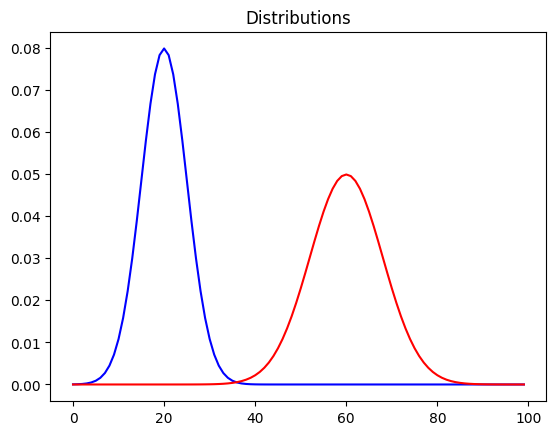

In [154]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 100
x = np.arange(n, dtype=np.float64)

m1 = n * 0.2
m2 = n * 0.6
s1 = n * 0.05
s2 = n * 0.08

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=m1, s=s1)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=m2, s=s2)

fig, ax = plt.subplots()
ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.set_title('Distributions')

plt.show()

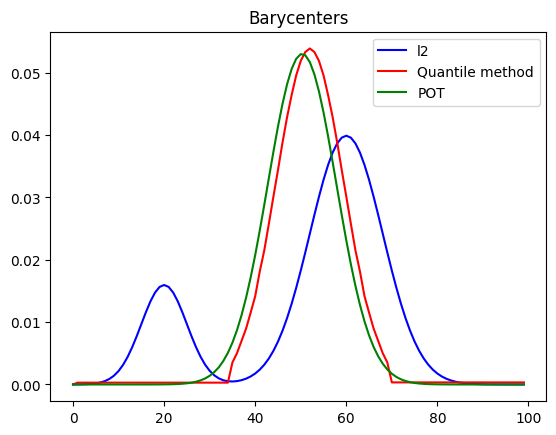

In [156]:
# Optimal transport

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

alpha = 0.8  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# l2bary
bary_l2 = A.dot(weights)

# barycenter
reg = 1e-3
bary_pot = ot.bregman.barycenter(A, M, reg, weights)
bary_quantile, _, _  = get_barycenter(A.T, x, n, 1-alpha)

fig, ax = plt.subplots()

ax.plot(x, bary_l2, 'b', label='l2')
ax.plot(x, bary_quantile, 'r', label='Quantile method')
ax.plot(x, bary_pot, 'g', label='POT')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a pure signal

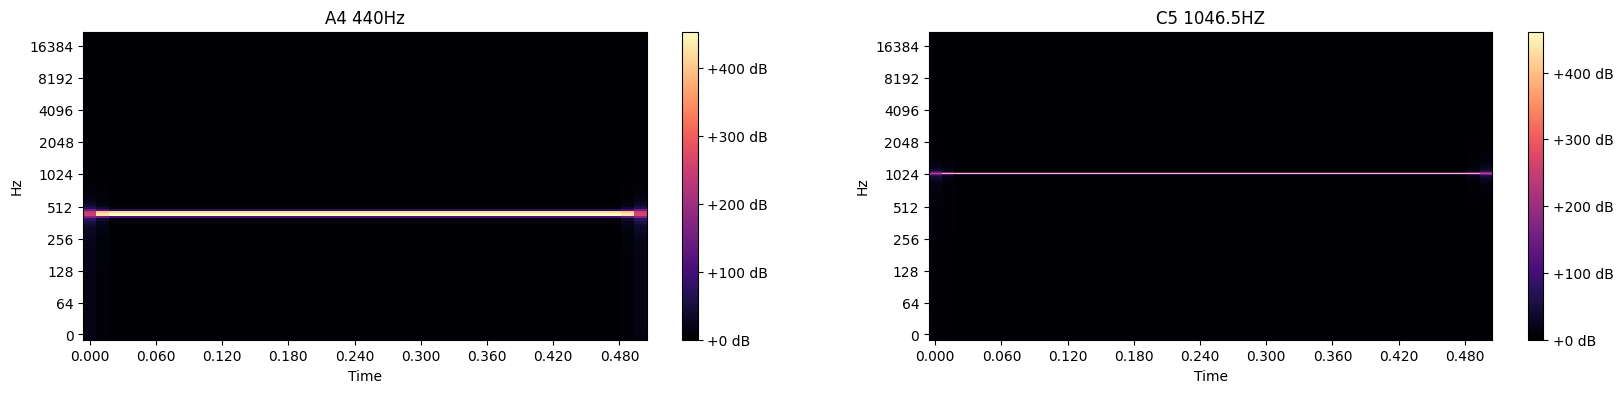

In [157]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.5
frames = np.arange(duration * sr) / sr

A4_freq = 440
A4_signal = np.sin(2 * np.pi * A4_freq * frames)

C5_freq = 1046.5
C5_signal = np.sin(2 * np.pi * C5_freq * frames)

n_fft = 2048
A4_fft = librosa.stft(A4_signal, n_fft=n_fft)
C5_fft = librosa.stft(C5_signal, n_fft=n_fft)

fig, ax = plt.subplots(1,2, figsize=(20,4))
img_A4 = librosa.display.specshow(np.abs(A4_fft), y_axis='log', x_axis='time', ax=ax[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
img_C5 = librosa.display.specshow(np.abs(C5_fft), y_axis='log', x_axis='time', ax=ax[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
ax[0].set_title('A4 440Hz')
ax[1].set_title('C5 1046.5HZ')
fig.colorbar(img_A4, ax=ax[0], format="%+2.0f dB")
fig.colorbar(img_C5, ax=ax[1], format="%+2.0f dB")

In [158]:
n = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
F = len(n) # nb of frequency bins
M = ot.utils.dist0(F)
M /= M.max()

A4_abs = np.abs(A4_fft)
C5_abs = np.abs(C5_fft)

B_pot = []
B_quantile = []
B_emd = []
B_L2 = []

alpha = 0.2
reg = 1e-3

for index in range(A4_fft.shape[1]):
    A4_norm = A4_abs[:, index] # magnitude spectrogram
    A4_norm /= np.sum(A4_norm) # normalization 
    C5_norm = C5_abs[:, index]
    C5_norm /= np.sum(C5_norm)

    A = np.vstack((A4_norm, C5_norm)).T
    weights = np.array([1 - alpha, alpha])

    B_L2.append(A.dot(weights))

    # wasserstein
    B_pot.append(ot.bregman.barycenter(A, M, reg, weights))

    # quantile
    bary_quantile, _, _  = get_barycenter(A.T, np.arange(F), F, 1-alpha)
    B_quantile.append(bary_quantile)

B_quantile = np.array(B_quantile).T
B_pot = np.array(B_pot).T
B_L2 = np.array(B_L2).T


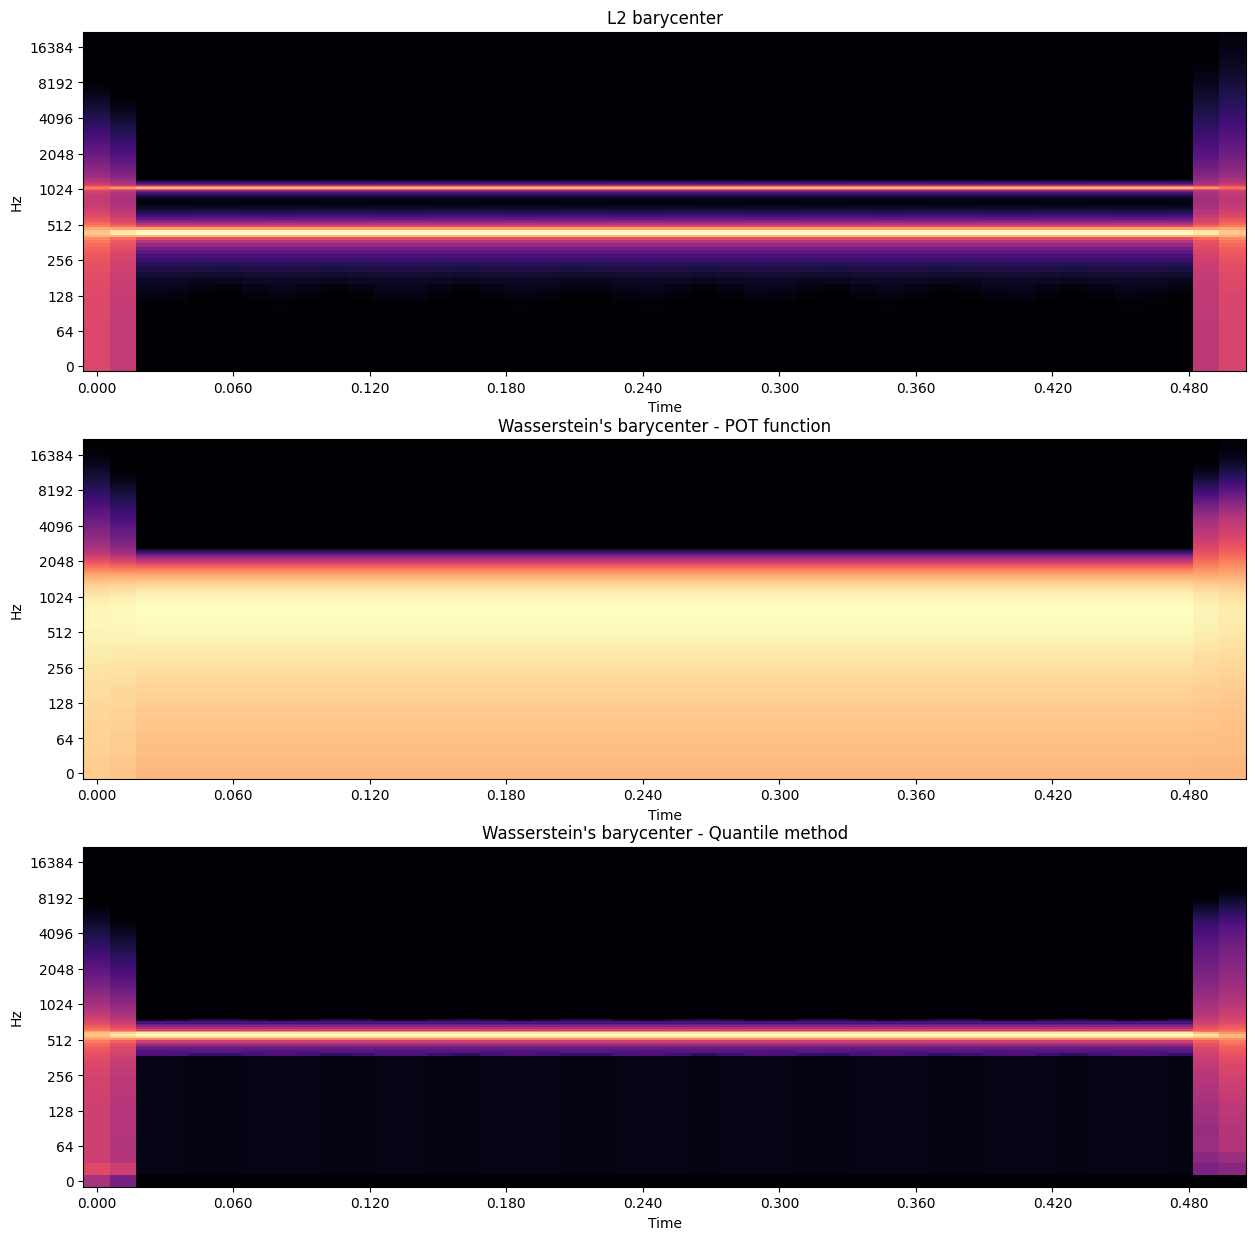

In [160]:
n_frames = len(B_pot[0])

# set nan entries to zero
for i in range(F):
    for j in range(n_frames):
        if B_pot[i][j] != B_pot[i][j]:
            B_pot[i][j] = 0
        if B_quantile[i][j] != B_quantile[i][j]:
            B_quantile[i][j] = 0

fig, ax = plt.subplots(3, 1, figsize=(15,15))
librosa.display.specshow(librosa.amplitude_to_db(B_L2, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(B_pot, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[1])
librosa.display.specshow(librosa.amplitude_to_db(B_quantile, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[2])
ax[0].set_title("L2 barycenter")
ax[1].set_title("Wasserstein's barycenter - POT function")
ax[2].set_title("Wasserstein's barycenter - Quantile method")
plt.show()

In [161]:
# display sounds

interpolated_signal_L2 = librosa.griffinlim(B_L2, n_iter = 100, n_fft=n_fft)
interpolated_signal_wass = librosa.griffinlim(B_pot, n_iter = 100, n_fft=n_fft)
interpolated_signal_quantile = librosa.griffinlim(B_quantile, n_iter = 100, n_fft=n_fft)

interpolated_signal_L2 = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_L2 / np.max(interpolated_signal_L2)
interpolated_signal_wass = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_wass / np.max(interpolated_signal_wass)
interpolated_signal_quantile = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_quantile / np.max(interpolated_signal_quantile)

audio_widgets = []

title = widgets.Label(f'L2 barcenter')
audio_player = IPython.display.Audio(data=interpolated_signal_L2, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Wasserstein barycenter - POT')
audio_player = IPython.display.Audio(data=interpolated_signal_wass, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Wasserstein barycenter - Quantile method')
audio_player = IPython.display.Audio(data=interpolated_signal_quantile, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

# On a real signal

/var/folders/0f/q6_npq51017f1x2tyhw_jqf00000gp/T/ipykernel_1118/2057387735.py:11: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(A_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
/var/folders/0f/q6_npq51017f1x2tyhw_jqf00000gp/T/ipykernel_1118/2057387735.py:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(C_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)


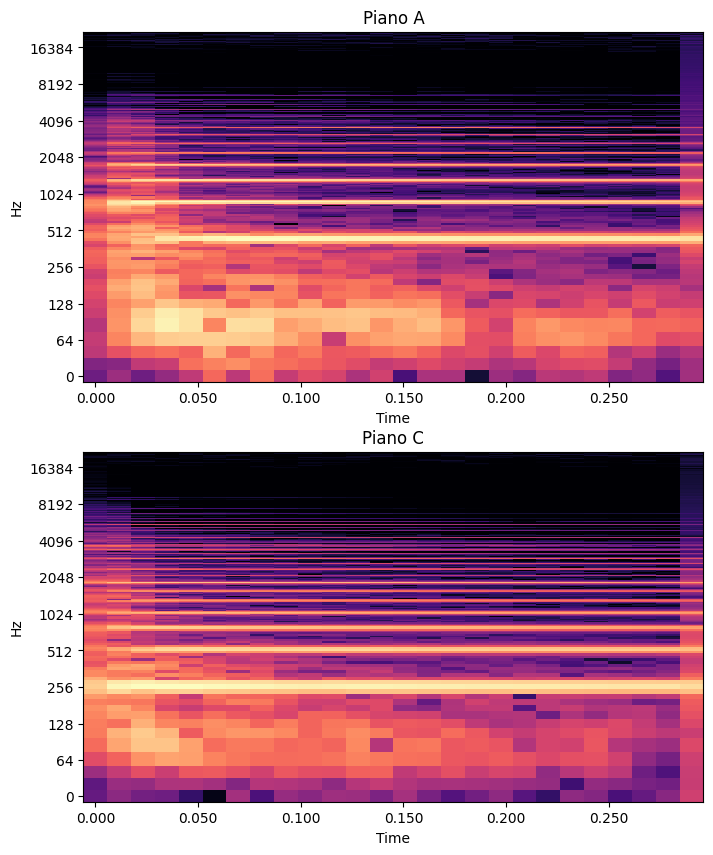

In [162]:
duration = 0.3 # in seconds

A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)

n_fft = 2048
A_stft = librosa.stft(A_signal, n_fft=n_fft)
C_stft = librosa.stft(C_signal, n_fft=n_fft)

fig, axs = plt.subplots(2,1, figsize=(8, 10))
librosa.display.specshow(librosa.amplitude_to_db(A_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(librosa.amplitude_to_db(C_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
axs[0].set_title(f"Piano A")
axs[1].set_title(f"Piano C")
plt.show()


In [163]:
n = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
F = len(n)
M = ot.utils.dist0(F)
M /= M.max()

A_abs = np.abs(A_stft)
C_abs = np.abs(C_stft)

B_pot = []
B_quantile = []
B_L2 = []

alpha = 0.2
reg = 1e-3

for index in range(A_abs.shape[1]):
    A_norm = A_abs[:, index]
    A_norm /= np.sum(A_norm)
    C_norm = C_abs[:, index]
    C_norm /= np.sum(C_norm)

    weights = np.array([1 - alpha, alpha])
    A = np.vstack((A_norm, C_norm)).T

    B_L2.append(A.dot(weights))

    # wasserstein
    B_pot.append(ot.bregman.barycenter(A, M, reg, weights))

    # quantile
    bary_quantile, _, _  = get_barycenter(A.T, np.arange(F), F, 1-alpha)
    B_quantile.append(bary_quantile)

B_quantile = np.array(B_quantile).T
B_pot = np.array(B_pot).T
B_L2 = np.array(B_L2).T


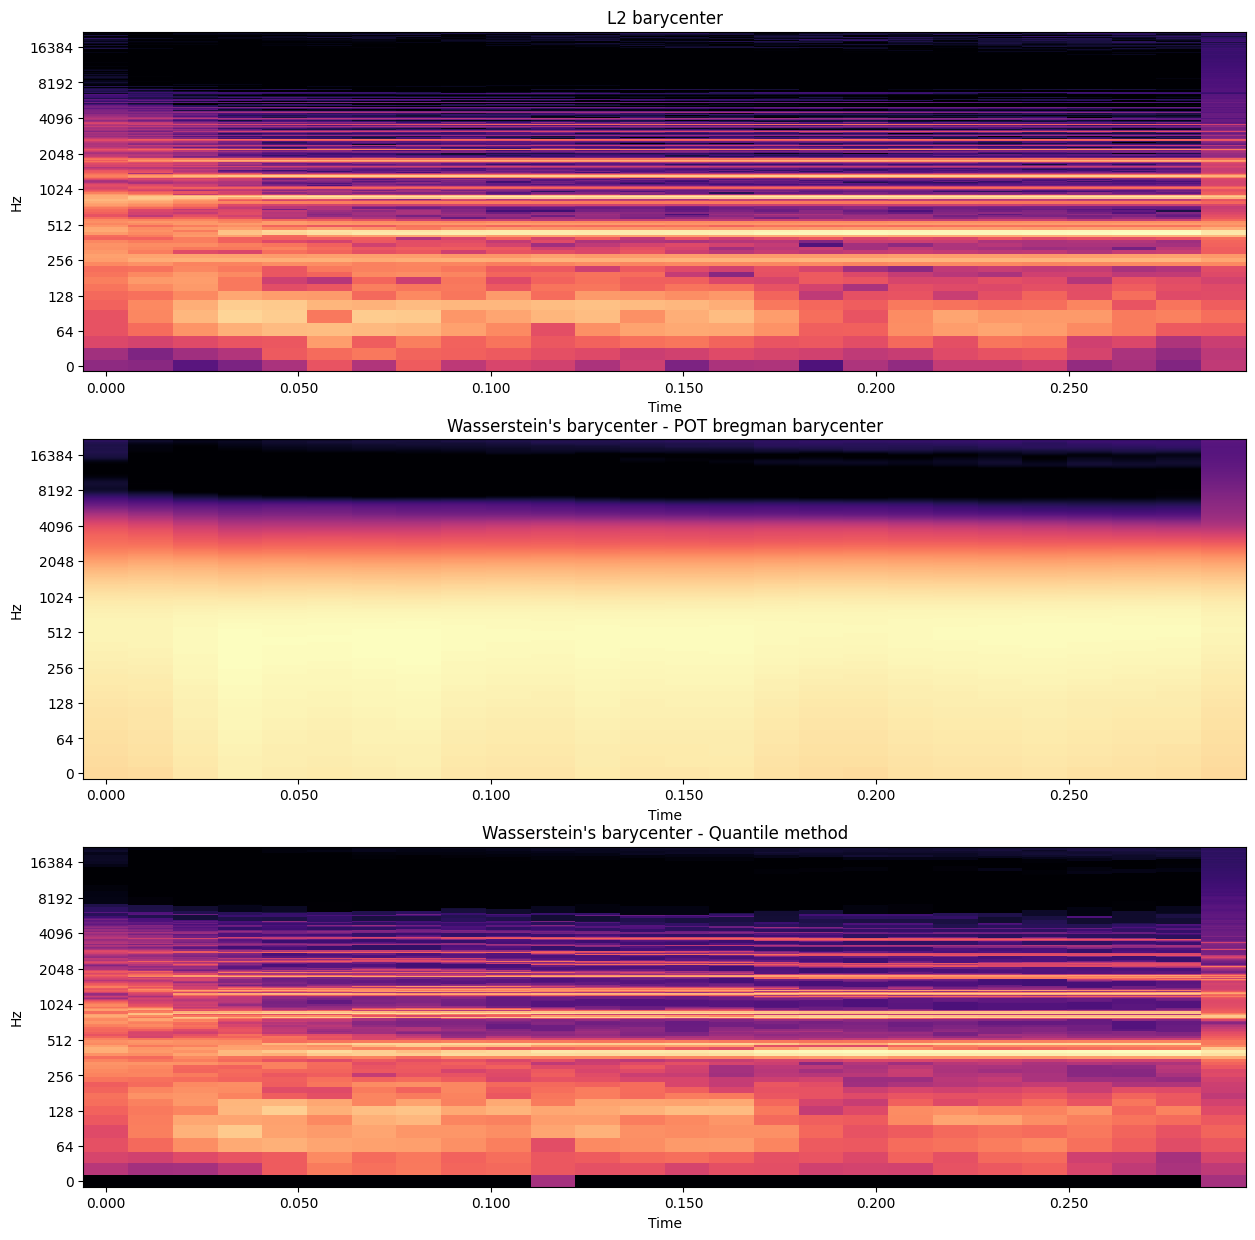

In [165]:
n_frames = len(B_pot[0])

# set nan entries to zero
for i in range(F):
    for j in range(n_frames):
        if B_pot[i][j] != B_pot[i][j]:
            B_pot[i][j] = 0
        if B_quantile[i][j] != B_quantile[i][j]:
            B_quantile[i][j] = 0

fig, ax = plt.subplots(3, 1, figsize=(15,15))
librosa.display.specshow(librosa.amplitude_to_db(B_L2, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(B_pot, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[1])
librosa.display.specshow(librosa.amplitude_to_db(B_quantile, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4, ax=ax[2])
ax[0].set_title("L2 barycenter")
ax[1].set_title("Wasserstein's barycenter - POT bregman barycenter")
ax[2].set_title("Wasserstein's barycenter - Quantile method")
plt.show()

In [166]:
# display sounds

interpolated_signal_L2 = librosa.griffinlim(B_L2, n_iter = 100, n_fft=n_fft)
interpolated_signal_wass = librosa.griffinlim(B_pot, n_iter = 100, n_fft=n_fft)
interpolated_signal_quantile = librosa.griffinlim(B_quantile, n_iter = 100, n_fft=n_fft)

interpolated_signal_L2 = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_L2 / np.max(interpolated_signal_L2)
interpolated_signal_wass = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_wass / np.max(interpolated_signal_wass)
interpolated_signal_quantile = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal_quantile / np.max(interpolated_signal_quantile)

audio_widgets = []

title = widgets.Label(f'L2 barcenter')
audio_player = IPython.display.Audio(data=interpolated_signal_L2, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Wasserstein barycenter - POT')
audio_player = IPython.display.Audio(data=interpolated_signal_wass, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Wasserstein barycenter - Quantile method')
audio_player = IPython.display.Audio(data=interpolated_signal_quantile, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid